In [1]:
"""Position Importance Score"""
from torch.nn.functional import softmax
import torch
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
"""Parameters"""
WORK_DIR = Path("../bert/exp/attns/cluster")
ATTNS = WORK_DIR / 'attns.pkl'
TOKENS = WORK_DIR / 'tokens.pkl'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
aminos = list('AGVLIFWPDEKRHSTNQYCM')
token2int = {x: i for i, x in enumerate(list(aminos))}
norm_fn = torch.linalg.norm


In [3]:
"""Functions"""
def position2token(sentence: str, positions: list):
    rtn = []
    for i, token in enumerate(sentence):
        if i in positions:
            rtn.append(token)
        else:
            rtn.append('_')
    return ''.join(rtn)


def visualize_token2token_scores(scores_mat, all_tokens, n_row=4, n_col=3, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20), dpi=600)
    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(n_row, n_col, idx+1)  # 修改以a适应层数
        # append the attention weights
        im = ax.imshow(scores_np, cmap='Blues')
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))
        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))
        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


def visualize_token2head_scores(scores_mat, all_tokens):
    fig = plt.figure(figsize=(30, 50), dpi=600)
    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 4, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='Blues')
        fontdict = {'fontsize': 20}
        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))
        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))
        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


In [4]:
"""Read Data"""
SELECT_PEP = 0  # whuich peptide
LAYER = 11  # which layer

with open(ATTNS, 'rb') as fattns:
    attns = pickle.load(fattns)  # [n, layers, heads, len, len]
with open(TOKENS, 'rb') as ftokens:
    tokens = pickle.load(ftokens)  # len = n
all_tokens = tokens[SELECT_PEP]
output_attentions_all = attns[SELECT_PEP].unsqueeze(1)
visualize_token2token_scores(output_attentions_all[LAYER].squeeze().detach().cpu().numpy(), all_tokens)

In [5]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), all_tokens,  4, 3, x_label_name='Layer')

In [7]:
""""A Negative Example"""
SELECT_PEP_NEG = -1
all_tokens_neg = tokens[SELECT_PEP_NEG]
output_attentions_all_neg = attns[SELECT_PEP_NEG].unsqueeze(1)
visualize_token2token_scores(output_attentions_all_neg[LAYER].squeeze().detach().cpu().numpy(), all_tokens_neg)

In [8]:
visualize_token2token_scores(norm_fn(output_attentions_all_neg, dim=2).squeeze().detach().cpu().numpy(), all_tokens_neg,  4, 3, x_label_name='Layer')

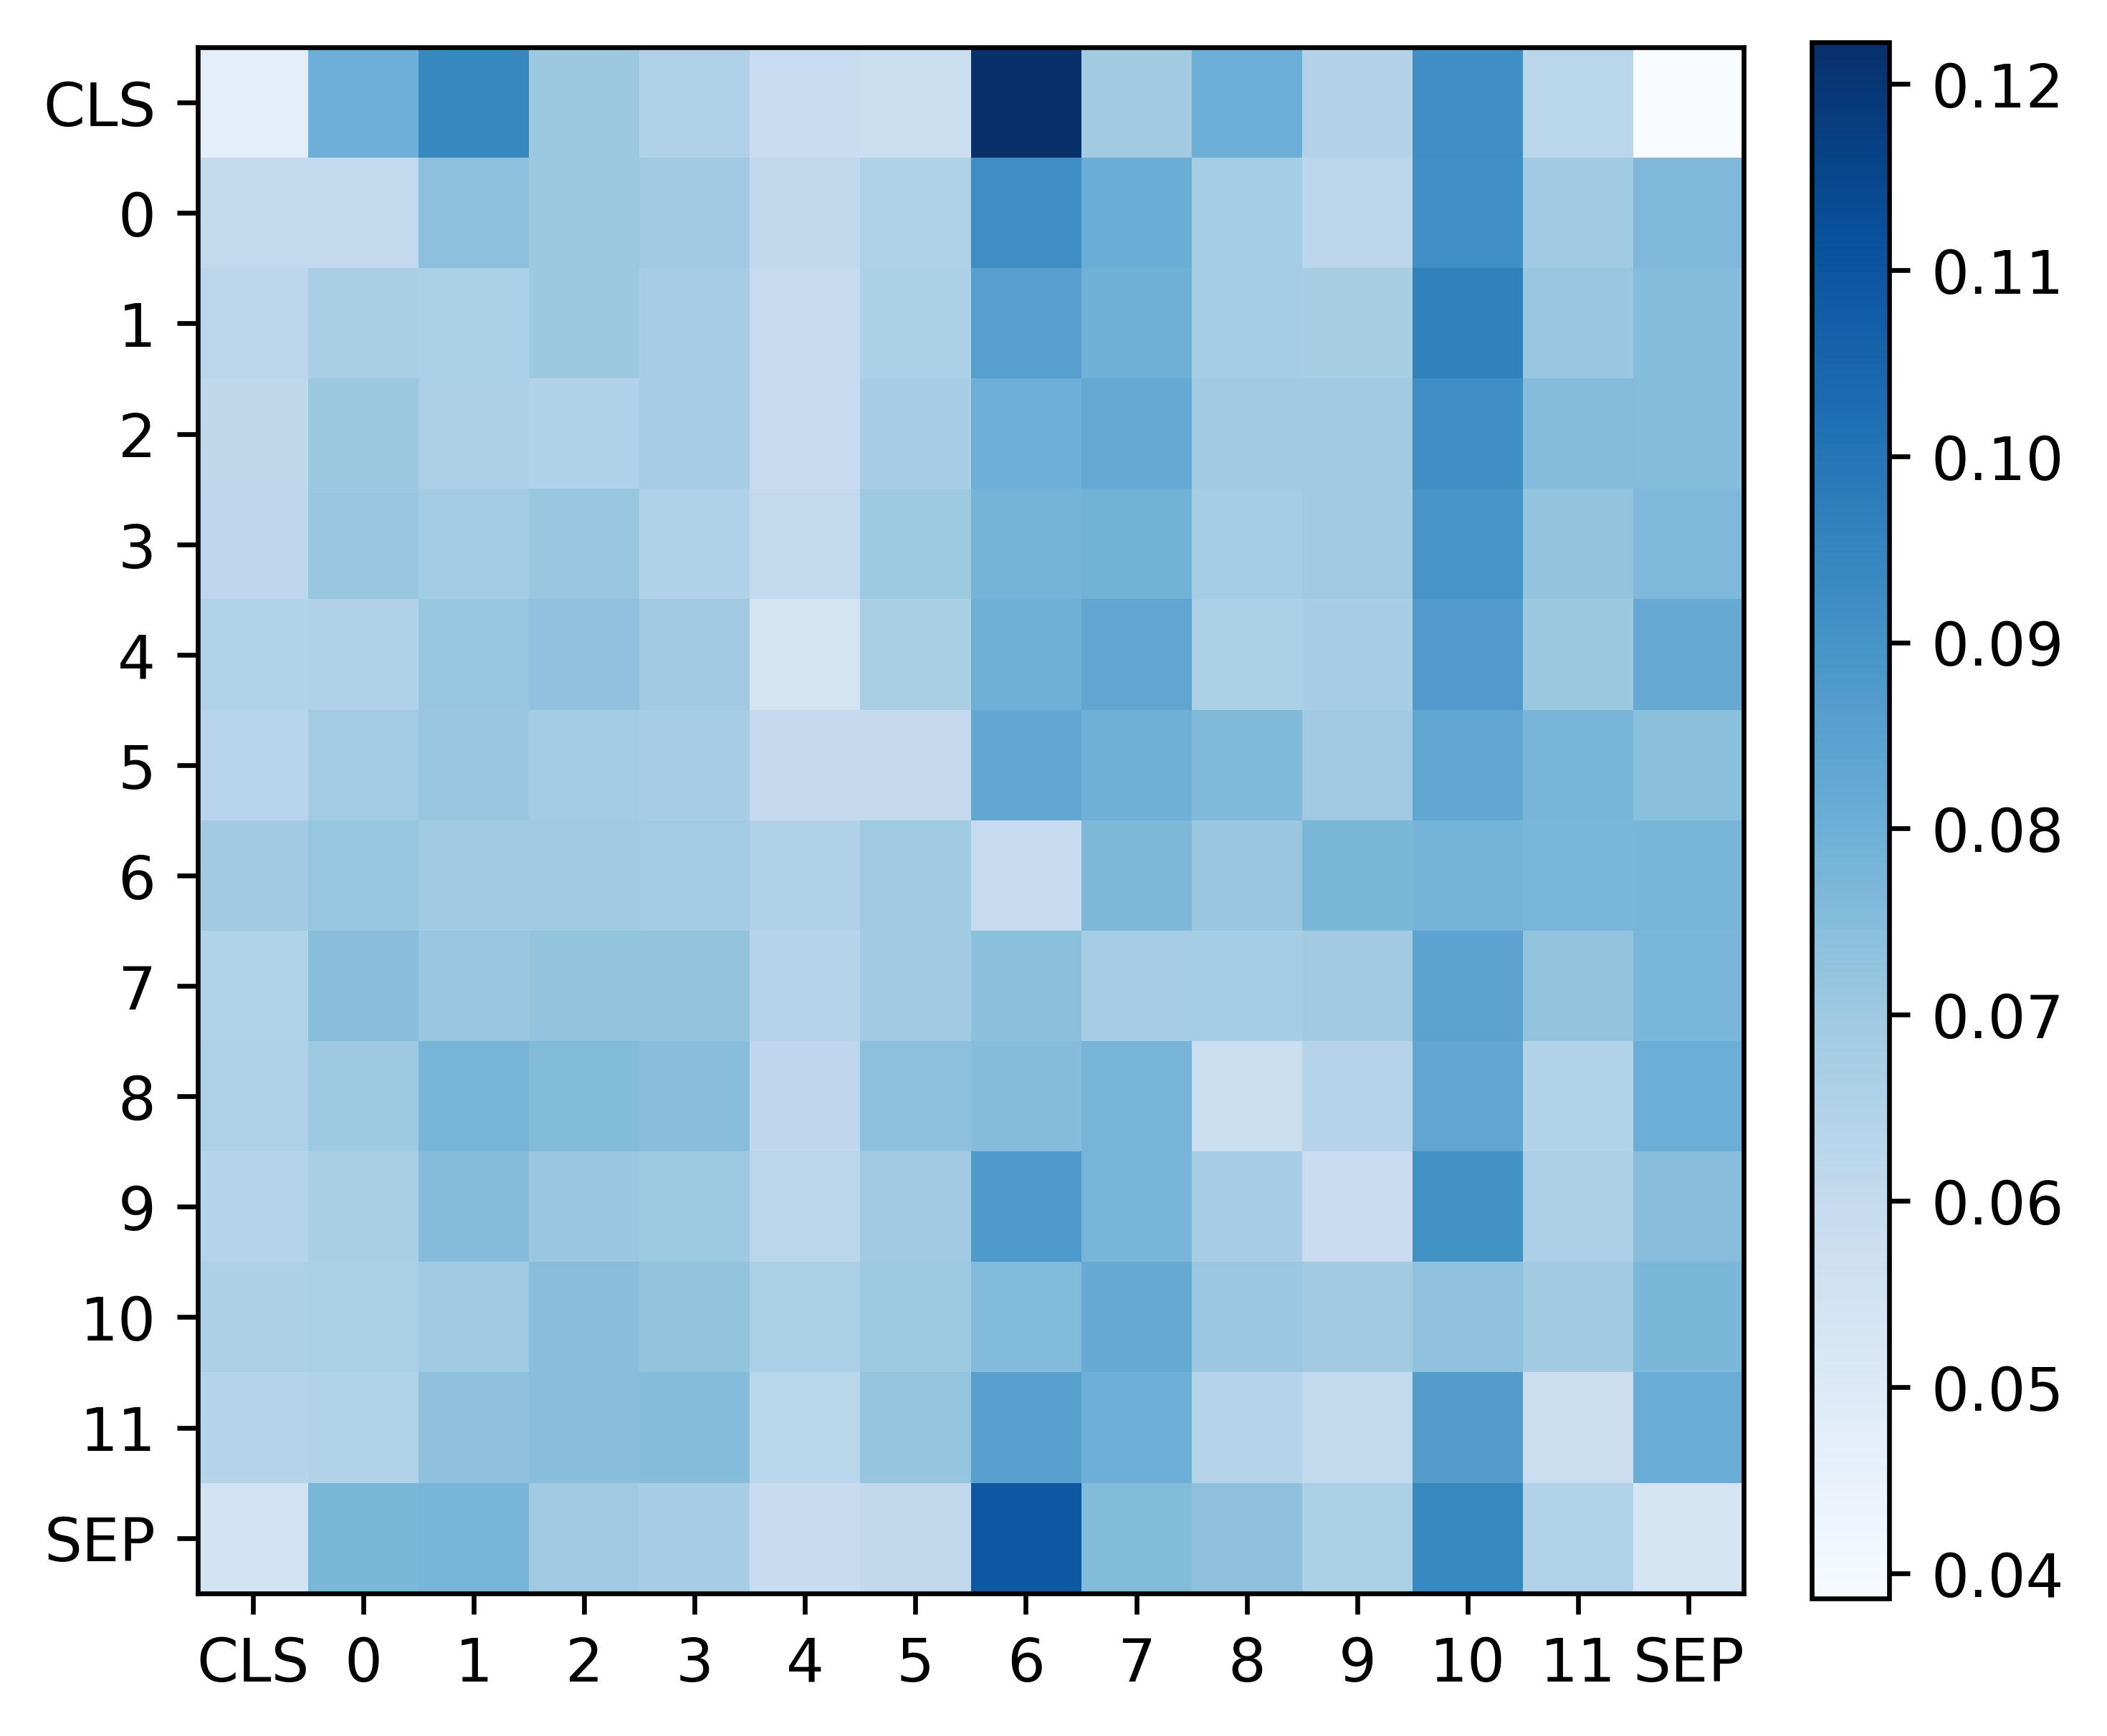

In [10]:
"""Plot the one"""
xticklabels = ['CLS'] + [str(i) for i in range(12)] + ['SEP']
yticklabels = ['CLS'] + [str(i) for i in range(12)] + ['SEP']


def visualize_pos2pos_scores(scores):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=600)
    scores_np = np.array(scores)
    im = ax.imshow(scores_np, cmap='Blues')
    fontdict = {'fontsize': 10}
    ax.set_xticks(range(14))
    ax.set_yticks(range(14))
    ax.set_xticklabels(xticklabels, fontdict=fontdict)
    ax.set_yticklabels(yticklabels, fontdict=fontdict)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


visualize_pos2pos_scores(attns[:99, 11:, :, :, :].mean(dim=[0, 1, 2]).squeeze())


In [21]:
"""Position Importance Score from Attention Matrix"""
from typing import List
from collections import Counter
import pandas as pd


def ext(pep: str, i: int):
    return pep[i]


def variable_score(action_set: List[Counter], z):
    len_actions = []
    head_scores = []
    for _, actions in enumerate(action_set):
        heads = [c for _, c in actions.most_common(3)]
        head_scores.append(sum(heads))
        len_actions.append(len(actions))
    len_score = np.array(len_actions)
    head_score = np.array(head_scores)
    attn_score = z.numpy()
    return len_score / head_score / attn_score


def get_importance_score(nfront: int=60, nlayer: int=11, show=False):
    x = attns[:nfront, nlayer:, :, 0:1, 1:13].sum(dim=[0, 1, 2, 3])
    y = attns[:nfront, nlayer:, :, 1:13, 0:1].sum(dim=[0, 1, 2, 4])
    z = x + y
    action_set = []
    df = pd.read_csv('../data/del1/cluster.csv').iloc[:nfront]

    for i in range(12):  # 12 positions
        action_set.append(Counter(df.seq.apply(ext, args=(i,))))

    position_scores = [round(a, 6)
                       for a in variable_score(action_set, z).tolist()]

    ranks = np.argsort(position_scores)

    _pep = list('HHYYRILYGELG')
    for i in ranks[6:]:
        _pep[i] = '_'
    result = ''.join(_pep)
    if show:
        print(ranks)
        print(position_scores)
        print(result)
    return result

In [25]:
get_importance_score(show=True)

[ 6 10  7  2  3  8  1  9 11  0  4  5]
[0.00125, 0.001091, 0.000945, 0.000964, 0.001412, 0.001424, 0.000491, 0.00088, 0.000995, 0.001116, 0.000755, 0.00116]
__YY__LYG_L_


'__YY__LYG_L_'